# Data Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# package imports

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import svm, metrics, model_selection
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import statistics
from sklearn.metrics import classification_report, confusion_matrix

from ast import literal_eval

import time
import datetime


import json

from random import sample
from random import seed

from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
import os
from PIL import Image

from keras.preprocessing.image import ImageDataGenerator
#import tensorflow_addons as tfa

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras import regularizers as reg

from keras.callbacks import ModelCheckpoint

from sklearn.utils import resample

In [ ]:
base_path = "/content/drive/MyDrive/DL Project/Covid/data_upload_v3/"

# train
train_nocovid_path = "train/non/"
entries_train_nocovid = os.listdir(base_path + train_nocovid_path)
entries_train_nocovid = [train_nocovid_path + entry for entry in entries_train_nocovid]
print(entries_train_nocovid[0])
train_covid_path = "train/covid/"
entries_train_covid = os.listdir(base_path + train_covid_path)
entries_train_covid = [train_covid_path + entry for entry in entries_train_covid]
print(entries_train_covid[0])

#test
test_nocovid_path = "test/non_all/"
entries_test_nocovid = os.listdir(base_path + test_nocovid_path)
entries_test_nocovid = [test_nocovid_path + entry for entry in entries_test_nocovid]
print(entries_test_nocovid[0])
test_covid_path = "test/covid/"
entries_test_covid = os.listdir(base_path + test_covid_path)
entries_test_covid = [test_covid_path + entry for entry in entries_test_covid]
print(entries_test_covid[0])

# Size of dataset
print("Train no covid: " + str(len(entries_train_nocovid)))
print("Train covid: " + str(len(entries_train_covid)))
print("Test no covid: " + str(len(entries_test_nocovid)))
print("Test covid: " + str(len(entries_test_covid)))

train/non/No Finding-patient12754-study1-view1_frontal.jpg
train/covid/1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg
test/non_all/patient05879-study2-view1_frontal.jpg
test/covid/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-002-fig3b.png
Train no covid: 2000
Train covid: 84
Test no covid: 3000
Test covid: 100


In [ ]:
metrics = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
def build_model(optimizer = 'adam'):
    classifier = Sequential()
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = metrics)
    return classifier
    
def add_cnl(classifier, neurons, strd = (3, 3), p_size = (2,2), n = 0, drop = 0):
    if n == 0:
        classifier.add(Conv2D(neurons[0], strd, input_shape = (150, 150, 1), activation = 'relu'))
        classifier.add(MaxPooling2D(pool_size = p_size))
        for i in range(1, len(neurons)):
            classifier.add(Conv2D(neurons[i], strd, activation = 'relu'))
            classifier.add(MaxPooling2D(pool_size = p_size))
            
    else:
        classifier.add(Conv2D(neurons, strd, input_shape = (150, 150, 1), activation = 'relu'))
        for i in range(1, n):
            classifier.add(Conv2D(neurons, strd, activation = 'relu'))
            classifier.add(MaxPooling2D(pool_size = p_size))

    classifier.add(Flatten())
        
    if drop != 0:
        classifier.add(Dropout(drop))

def add_dense(classifier, neurons, n = 0, end = True, reg = None):
    if n == 0:
        for neu in neurons:
            classifier.add(Dense(neu,kernel_regularizer = reg, activation = 'relu'))

    else:
        for i in range(n):
            classifier.add(Dense(neurons,kernel_regularizer = reg ,activation = 'relu'))
    
    if end:
        classifier.add(Dense(units = 1, activation = 'sigmoid'))

#Oversampling


def oversampling(traindf):
    covid_df_upsampled = resample(traindf.loc[traindf["class"]=="1"],
                          replace=True, # sample with replacement
                          n_samples=len(traindf.loc[traindf["class"]=="0"]), # match number in majority class
                          random_state=23) # reproducible results
    upsampled= pd.concat([covid_df_upsampled, traindf.loc[traindf["class"]=="0"]])
    return upsampled

In [3]:
def plot_metrics(history, metrics = ['loss',  "accuracy" ,'auc', 'precision', 'recall',"f1"]):
  
  if "f1" in metrics:
    precision = history["precision"]
    recall = history["recall"]
    precision_val = history["val_precision"]
    recall_val = history["val_recall"]
    f1 = []
    f1_val = []
    for i in range(len(precision)):
      if (precision[i]+recall[i]) == 0:
        f1_single = 0
      else:
        f1_single = (2*precision[i]*recall[i])/(precision[i]+recall[i])
      if (precision_val[i]+recall_val[i]) == 0:
        f1_val_single = 0
      else:
        f1_val_single = (2*precision_val[i]*recall_val[i])/(precision_val[i]+recall_val[i])
      f1.append(f1_single)
      f1_val.append(f1_val_single)
    history["f1"] = f1
    history["val_f1"] = f1_val
  plt.figure(figsize=(15,15))
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(range(len(history[metric])), history[metric], label='Train')
    plt.plot(range(len(history[metric])), history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    plt.legend()
  plt.show(block=False)

In [ ]:
X_train_paths = entries_train_nocovid + entries_train_covid
# merging array of 0's for each no covid image and array of 1's for each covid image
y_train_labels = [ 0 for i in range(len(entries_train_nocovid))] + [ 1 for i in range(len(entries_train_covid))]

X_test_paths = entries_test_nocovid + entries_test_covid
# merging array of 0's for each no covid image and array of 1's for each covid image
y_test_labels = [ 0 for i in range(len(entries_test_nocovid))] + [ 1 for i in range(len(entries_test_covid))]

# Visualization of Image Augmentation

In [ ]:
#Visualization of Image Augmentation

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import expand_dims

# load the image
chosen_image = base_path + X[2082]
img = load_img(chosen_image)
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)

# prepare iterator
it = train_datagen.flow(samples, batch_size=1)
# generate samples and plot
plt.figure(figsize=(16,15))
for i in range(9):
    #define subplot
    plt.subplot(3,3,i+1)
    # generate batch of images
    batch = it.next()
    image = batch[0]
    plt.imshow(image)
plt.show()

NameError: ignored

# Models

In [ ]:
model = build_model(optimizer = 'rmsprop')
add_cnl(model,neurons = 32, n = 2, strd = (4, 4) ) #
add_dense(model, neurons = 32, n = 2 )

In [ ]:
model = build_model()
add_cnl(model,neurons = 32, n=1, p_size = (3,3) ,drop = 0.2 ) #layers with different dimension
add_dense(model, neurons = [64, 32], reg= reg.l1_l2(0.001, 0.001) )

In [ ]:
model = build_model()
add_cnl(model,neurons = [32, 64]) #layers with different dimension
add_dense(model, neurons = 32, n = 2, reg = reg.l2(0.001)  )

## Training with class weights

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
w = compute_class_weight('balanced',  np.unique(y_train_labels),  y_train_labels)
class_weight = {0: w[0], 1: w[1]}

###### K Fold Validation step => 0 #####
Found 1875 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Epoch 1/60
7/7 [==============================] - 111s 3s/step - loss: 0.7052 - accuracy: 0.5119 - precision: 0.0415 - recall: 0.5756 - auc: 0.5188 - val_loss: 0.7465 - val_accuracy: 0.0431 - val_precision: 0.0431 - val_recall: 1.0000 - val_auc: 0.2497
Epoch 2/60
7/7 [==============================] - 6s 333ms/step - loss: 0.7052 - accuracy: 0.4089 - precision: 0.0376 - recall: 0.5477 - auc: 0.4950 - val_loss: 0.6771 - val_accuracy: 0.9569 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7981
Epoch 3/60
7/7 [==============================] - 11s 267ms/step - loss: 0.7187 - accuracy: 0.9071 - precision: 0.0899 - recall: 0.1869 - auc: 0.7387 - val_loss: 0.5258 - val_accuracy: 0.9569 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.9458
Epoch 4/60
7/7 [==============================] - 11s 252ms/

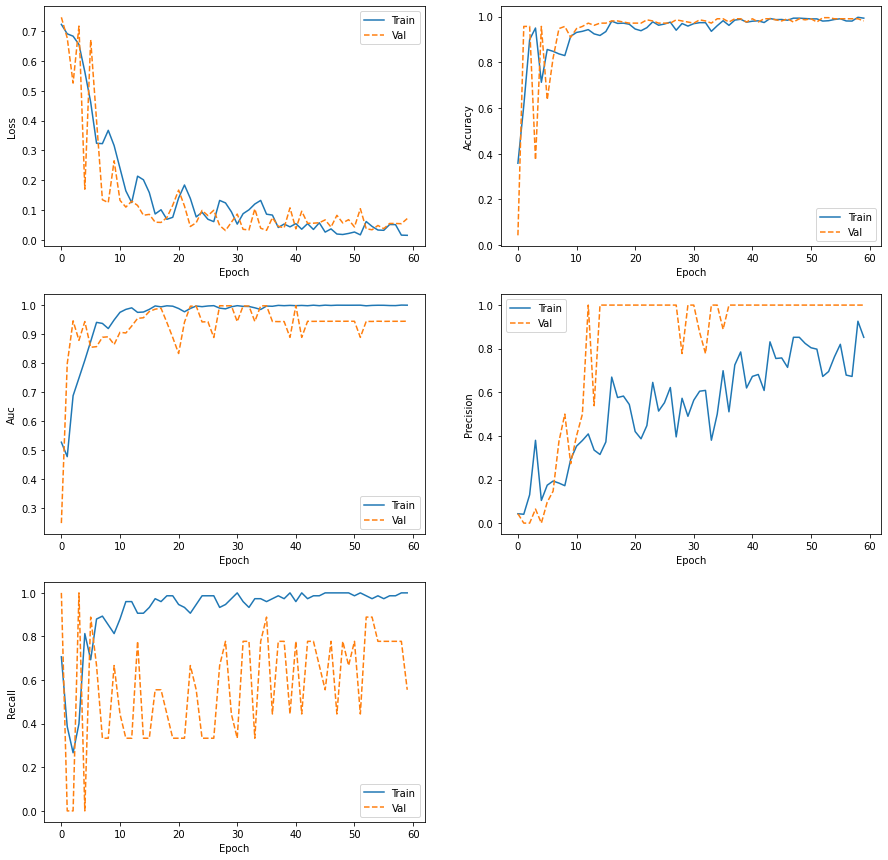

              precision    recall  f1-score   support

    No Covid       0.98      1.00      0.99       200
       Covid       1.00      0.56      0.71         9

    accuracy                           0.98       209
   macro avg       0.99      0.78      0.85       209
weighted avg       0.98      0.98      0.98       209



FileNotFoundError: ignored

In [ ]:
model_number = 1 
k = 10
number_of_its = 5
epochs = 60

kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)

X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 268
val_batch = 19

histories = []
reports = []

val_y_true_list = []
val_y_predictions_list = []

times = []

seed(42)
w = sample(range(k), number_of_its)
for i, (train_index, val_index) in enumerate(kf.split(X,y)):
#    if i not in w:
#      continue
    
    time1 = time.time()
    train_paths = X[train_index]
    val_paths = X[val_index]
    train_label = y[train_index]
    val_labels = y[val_index]

    train_data = {'filename':train_paths, 
        'class': [str(i) for i in train_label]}
    train_df = pd.DataFrame(train_data)
    
    val_data = {'filename':val_paths, 
        'class': [str(i) for i in val_labels]}
    val_df = pd.DataFrame(val_data)


    print("###### K Fold Validation step => %d #####" % i)

    train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range=0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=[0.8, 1.3],
                                  brightness_range=[0.8,1.2],
                                  horizontal_flip=True,
                                  fill_mode = "constant")

    train_generator = train_datagen.flow_from_dataframe(train_df,
                                                       directory = base_path,
                                                       target_size= shape,
                                                       batch_size = train_batch,
                                                       color_mode = "grayscale", 
                                                       class_mode = "binary")
    
    val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                             directory = base_path,
                                                                             target_size = shape, 
                                                                             batch_size = val_batch,
                                                                             color_mode = "grayscale", 
                                                                             class_mode = "binary",
                                                                             shuffle = False)

    model1 = build_model()
    add_cnl(model1,neurons = [32, 64, 128], drop = 0.2 )
    add_dense(model1, neurons = 256, n = 2 )

    history = model1.fit(
            train_generator,
            steps_per_epoch=7,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=11,
            workers=8, class_weight=class_weight)
    histories.append(history.history)


    # EVALUATION

    filenames = val_generator.filenames
    nb_samples = len(filenames)
    Y_pred = model1.predict(val_generator, nb_samples) 
    Y_pred = (Y_pred>0.5)
    val_y_true_list.extend(val_generator.classes)
    val_y_predictions_list.extend(Y_pred)
    target_names = ['No Covid', 'Covid']
    report = classification_report(val_generator.classes, Y_pred, target_names=target_names)
    print('Classification Report')
    print(report)
    reports.append(report)

    # log time of fold
    time2 = time.time() - time1
    print(str(datetime.timedelta(seconds=time2)))
    times.append(str(datetime.timedelta(seconds=time2)))

#print classification reports and plot and save histories
for i in range(number_of_its):
  print("")
  print("Iteration " + str(i))
  plot_metrics(histories[i])
  print(reports[i])
  json.dump(histories[0], open("/content/drive/MyDrive/DL Project/Covid/histories/model"+str(i)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

print("")
print("Whole K-Fold Evaluation")
print('Confusion Matrix')
print(confusion_matrix(val_y_true_list, val_y_predictions_list))
print('Classification Report')
target_names = ['No Covid', 'Covid']
report = classification_report(val_y_true_list, val_y_predictions_list, target_names=target_names)
print(report)
print(times)
  

## Test set evaluation

In [ ]:
train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                              rotation_range = 20,
                              width_shift_range=0.1,
                              height_shift_range = 0.1,
                              zoom_range=[0.8, 1.3],
                              brightness_range=[0.8,1.2],
                              horizontal_flip=True,
                              fill_mode = "constant")

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory = base_path,
                                                    target_size= shape,
                                                    batch_size = train_batch,
                                                    color_mode = "grayscale", 
                                                    class_mode = "binary")

test_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(test_df, 
                                                                          directory = base_path,
                                                                          target_size = shape, 
                                                                          batch_size = val_batch,
                                                                          color_mode = "grayscale", 
                                                                          class_mode = "binary",
                                                                          shuffle = False)


Found 2084 validated image filenames belonging to 2 classes.
Found 3100 validated image filenames belonging to 2 classes.


In [ ]:
epochs = 40 #empirically should have somewhat converged


prova = build_model()
add_cnl(prova,neurons = [32, 64, 128], drop = 0.2 )
add_dense(prova, neurons = 256, n = 2 )

history = prova.fit(
        train_generator,
        steps_per_epoch=7,
        epochs=epochs,
        workers=8, class_weight=class_weight)

Epoch 1/40
7/7 [==============================] - 7s 210ms/step - loss: 0.9637 - accuracy: 0.3423 - precision: 0.0399 - recall: 0.6616 - auc: 0.5236
Epoch 2/40
7/7 [==============================] - 6s 124ms/step - loss: 0.6603 - accuracy: 0.5739 - precision: 0.0421 - recall: 0.4849 - auc: 0.5663
Epoch 3/40
7/7 [==============================] - 6s 256ms/step - loss: 0.6933 - accuracy: 0.7293 - precision: 0.2145 - recall: 0.5601 - auc: 0.6970
Epoch 4/40
7/7 [==============================] - 6s 94ms/step - loss: 0.6296 - accuracy: 0.8877 - precision: 0.1367 - recall: 0.3965 - auc: 0.7317
Epoch 5/40
7/7 [==============================] - 6s 297ms/step - loss: 0.6738 - accuracy: 0.7425 - precision: 0.1164 - recall: 0.7091 - auc: 0.7691
Epoch 6/40
7/7 [==============================] - 6s 107ms/step - loss: 0.5937 - accuracy: 0.5421 - precision: 0.0819 - recall: 0.8407 - auc: 0.8158
Epoch 7/40
7/7 [==============================] - 6s 95ms/step - loss: 0.4679 - accuracy: 0.8419 - precisio

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)
Y_pred = prova.predict(test_generator, nb_samples) 
Y_pred = (Y_pred>0.5)
test_y_true_list.extend(test_generator.classes)
test_y_predictions_list.extend(Y_pred)
target_names = ['No Covid', 'Covid']
report = classification_report(test_generator.classes, Y_pred, target_names=target_names)
print('Classification Report')
print(report)

KeyboardInterrupt: ignored

In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

In [ ]:
Y_pred = prova.predict(test_generator, nb_samples)
Y_pred = (Y_pred>0.5)

In [ ]:
test_y_true_list = []
test_y_predictions_list = []
test_y_true_list.extend(test_generator.classes)
test_y_predictions_list.extend(Y_pred)
target_names = ['No Covid', 'Covid']
report = classification_report(test_generator.classes, Y_pred, target_names=target_names)
print('Classification Report')
print(report)

Classification Report
              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00      3000
       Covid       1.00      0.79      0.88       100

    accuracy                           0.99      3100
   macro avg       1.00      0.90      0.94      3100
weighted avg       0.99      0.99      0.99      3100



In [ ]:
len(Y_pred)

3100

## **Oversampling with callbacks**

In [ ]:
model_number = 1
k = 10
number_of_its = 10
epochs = 20

kf = StratifiedKFold(n_splits=k, random_state=42, shuffle=True)
kf.get_n_splits(X_train_paths, y_train_labels)

X = np.array(X_train_paths)
y = np.array(y_train_labels)

shape = (150,150)
train_batch = 150
val_batch = 19

histories = []
reports = []

val_y_true_list = []
val_y_predictions_list = []

times = []


directories = ["/content/drive/MyDrive/DL Project/Covid/callbacks/model"+str(model_number)+"/fold"+str(i)+"/" for i in range(k)]
filepaths = [directories[i]+ "weights{epoch:01d}.hdf5" for i in range(k)]
for i in range(k):
  if not os.path.exists(directories[i]):
    os.makedirs(directories[i])
callbacks = [ModelCheckpoint(filepath = filepaths[i], verbose=0, save_best_only=False, save_weights_only=True) for i in range(k)]

generators = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

    time1 = time.time()
    train_paths = X[train_index]
    val_paths = X[val_index]
    train_label = y[train_index]
    val_labels = y[val_index]

    train_data = {'filename':train_paths, 
        'class': [str(i) for i in train_label]}
    train_df = pd.DataFrame(train_data)
    
    val_data = {'filename':val_paths, 
        'class': [str(i) for i in val_labels]}
    val_df = pd.DataFrame(val_data)
    
    oversampled_train_df = oversampling(train_df)


    print("###### K Fold Validation step => %d #####" % i)

    train_datagen = train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 20,
                                  width_shift_range=0.1,
                                  height_shift_range = 0.1,
                                  zoom_range=[0.8, 1.3],
                                  brightness_range=[0.8,1.2],
                                  horizontal_flip=True,
                                  fill_mode = "constant")

    train_generator = train_datagen.flow_from_dataframe(oversampled_train_df,
                                                       directory = base_path,
                                                       target_size= shape,
                                                       batch_size = train_batch,
                                                       color_mode = "grayscale", 
                                                       class_mode = "binary")
    
    val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                             directory = base_path,
                                                                             target_size = shape, 
                                                                             batch_size = val_batch,
                                                                             color_mode = "grayscale", 
                                                                             class_mode = "binary",
                                                                             shuffle = False)

    model = build_model()
    add_cnl(model,neurons = [32, 64, 128], drop = 0.2 )
    add_dense(model, neurons = 256, n = 2 )

    history = model.fit(
            train_generator,
            steps_per_epoch=24,
            epochs=epochs,
            validation_data=val_generator,
            validation_steps=11,
            workers=8, callbacks=[callbacks[i]])
    histories.append(history.history)


    # EVALUATION

    filenames = val_generator.filenames
    nb_samples = len(filenames)
    Y_pred = model.predict(val_generator, nb_samples) 
    Y_pred = (Y_pred>0.5)
    val_y_true_list.extend(val_generator.classes)
    val_y_predictions_list.extend(Y_pred)
    target_names = ['No Covid', 'Covid']
    report = classification_report(val_generator.classes, Y_pred, target_names=target_names)
    print('Classification Report')
    print(report)
    reports.append(report)

    # log time of fold
    time2 = time.time() - time1
    print(str(datetime.timedelta(seconds=time2)))
    times.append(str(datetime.timedelta(seconds=time2)))

###### K Fold Validation step => 0 #####
Found 3600 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Epoch 1/20
24/24 [==============================] - 46s 1s/step - loss: 0.7118 - accuracy: 0.6348 - precision: 0.6283 - recall: 0.6651 - auc: 0.7070 - val_loss: 0.7914 - val_accuracy: 0.3636 - val_precision: 0.0634 - val_recall: 1.0000 - val_auc: 0.8806
Epoch 2/20
24/24 [==============================] - 49s 1s/step - loss: 0.3961 - accuracy: 0.8185 - precision: 0.8155 - recall: 0.8356 - auc: 0.9112 - val_loss: 0.1294 - val_accuracy: 0.9378 - val_precision: 0.3333 - val_recall: 0.4444 - val_auc: 0.9194
Epoch 3/20
24/24 [==============================] - 52s 1s/step - loss: 0.1608 - accuracy: 0.9438 - precision: 0.9421 - recall: 0.9495 - auc: 0.9851 - val_loss: 0.0967 - val_accuracy: 0.9617 - val_precision: 0.5385 - val_recall: 0.7778 - val_auc: 0.9836
Epoch 4/20
24/24 [==============================] - 52s 1s/step - loss: 0.25

In [ ]:
best = []
for j in range(k):
    f1 = []
    p = histories[j]["val_precision"]
    r = histories[j]["val_recall"]
    for i in range(len(p)):
      f1.append(f1.append(2*(p[i]*r[i])/(p[i]+r[i]) if (p[i]+r[i])!=0 else 0))
    best.append(np.argmax(f1))
    print("FOLD: "+str(j)+ "best epoch: "+str(best[j]+1)+ "F1 score: "+str(f1[best[j]]))
val_epoch = int(np.mean(best))


val_y_true_list = []
val_y_predictions_list = []
for i, (train_index, val_index) in enumerate(kf.split(X,y)):

  val_paths = X[val_index]
  val_labels = y[val_index]
  
  val_data = {'filename':val_paths, 
      'class': [str(i) for i in val_labels]}
  val_df = pd.DataFrame(val_data)
  val_generator = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(val_df, 
                                                                            directory = base_path,
                                                                            target_size = shape, 
                                                                            batch_size = val_batch,
                                                                            color_mode = "grayscale", 
                                                                            class_mode = "binary",
                                                                            shuffle = False)  
  
  model.load_weights(filepath = directories[i]+"weights"+str(val_epoch+1)+".hdf5")

  filenames = val_generator.filenames
  nb_samples = len(filenames)
  Y_pred = model.predict(val_generator, nb_samples) 
  Y_pred = (Y_pred>0.5)
  val_y_true_list.extend(val_generator.classes)
  val_y_predictions_list.extend(Y_pred)

if not os.path.exists("/content/drive/MyDrive/DL Project/Covid/histories/model"+str(model_number)):
    os.makedirs("/content/drive/MyDrive/DL Project/Covid/histories/model"+str(model_number))

#print classification reports and plot and save histories
for i in range(number_of_its):
  print("")
  print("Iteration " + str(i))
  plot_metrics(histories[i])
  print(reports[i])
  json.dump(histories[0], open("/content/drive/MyDrive/DL Project/Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'w'))

print("")
print("Whole K-Fold Evaluation")
print('Confusion Matrix')
print(confusion_matrix(val_y_true_list, val_y_predictions_list))
print('Classification Report')
target_names = ['No Covid', 'Covid']
report = classification_report(val_y_true_list, val_y_predictions_list, target_names=target_names)
print(report)
print(times)

FOLD: 0best epoch: 12F1 score: 0.7142857361812978
FOLD: 1best epoch: 8F1 score: 0.7142857361812978
FOLD: 2best epoch: 5F1 score: 0.9411764743006353
FOLD: 3best epoch: 4F1 score: 0.9411764743006353
FOLD: 4best epoch: 7F1 score: 0.7692307692307693
FOLD: 5best epoch: 9F1 score: 0.9333333333333333
FOLD: 6best epoch: 9F1 score: 0.9333333333333333
FOLD: 7best epoch: 9F1 score: 0.8571428571428571
FOLD: 8best epoch: 12F1 score: 0.9333333333333333
FOLD: 9best epoch: 14F1 score: 0.8571428571428571


Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 209 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.
Found 208 validated image filenames belonging to 2 classes.



Iteration 0


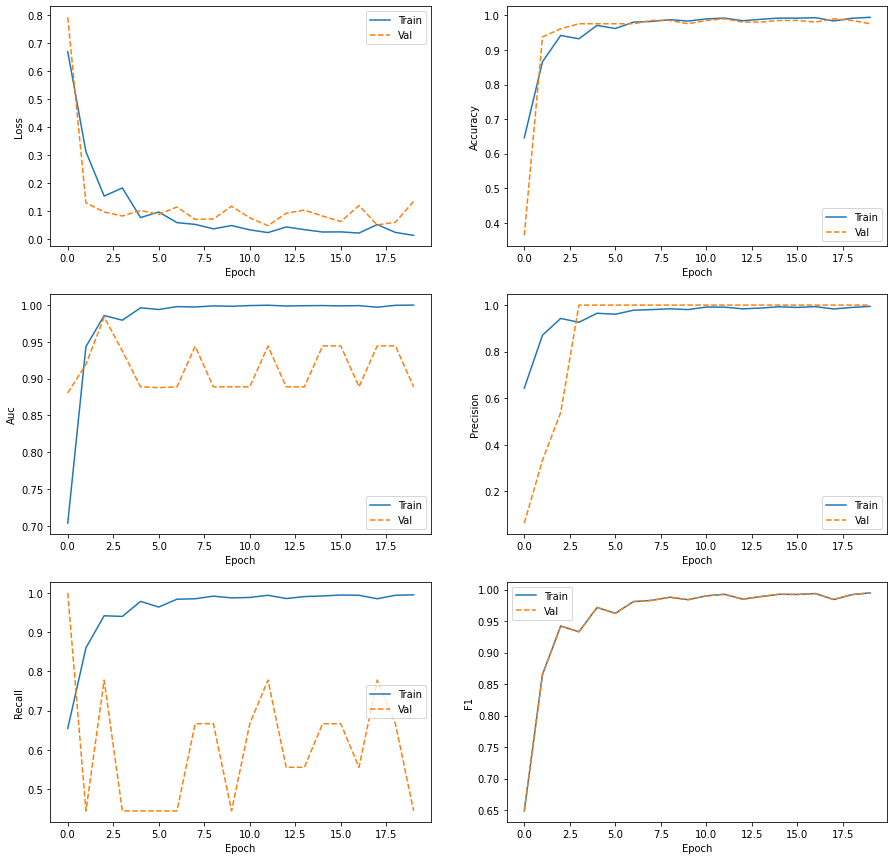

              precision    recall  f1-score   support

    No Covid       0.98      1.00      0.99       200
       Covid       1.00      0.44      0.62         9

    accuracy                           0.98       209
   macro avg       0.99      0.72      0.80       209
weighted avg       0.98      0.98      0.97       209


Iteration 1


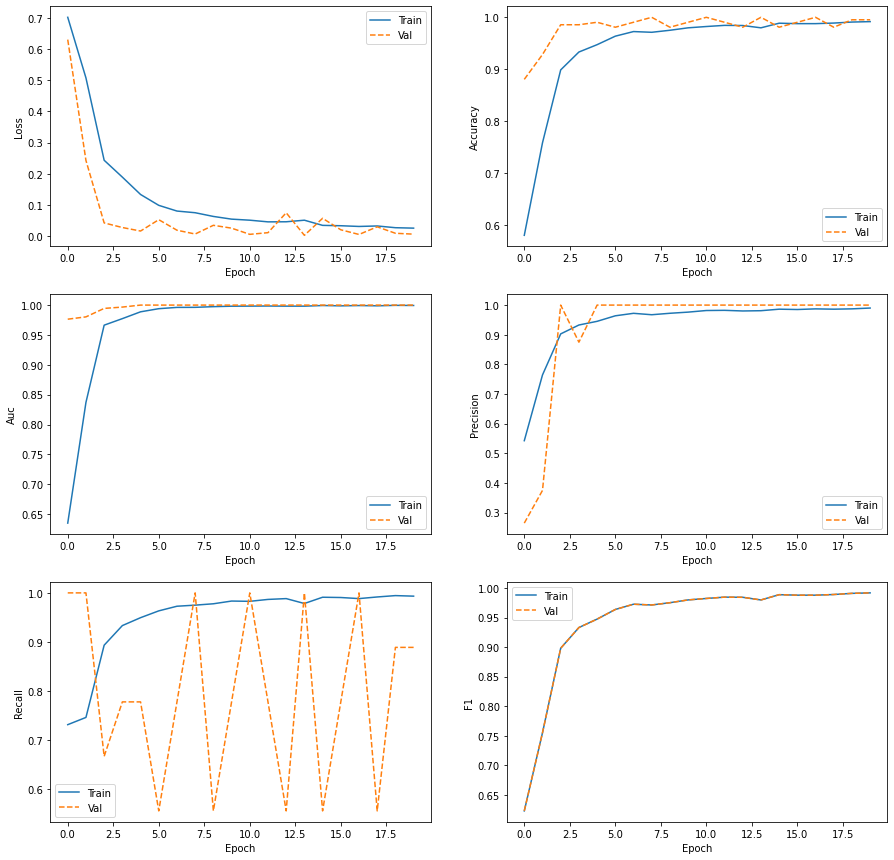

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.89      0.94         9

    accuracy                           1.00       209
   macro avg       1.00      0.94      0.97       209
weighted avg       1.00      1.00      1.00       209


Iteration 2


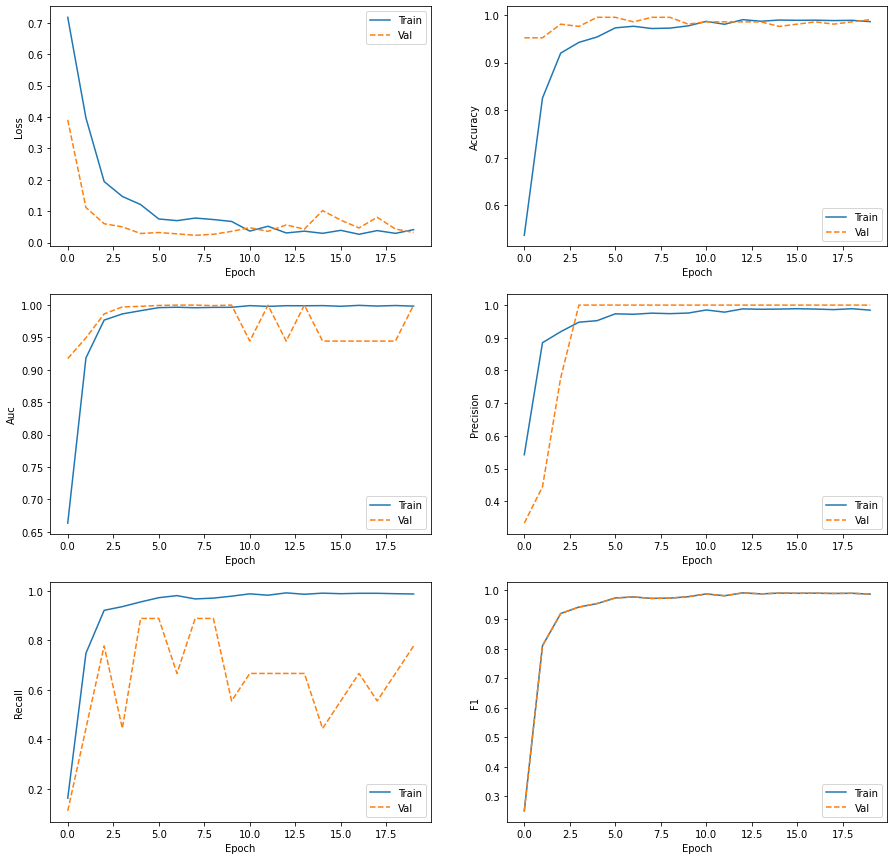

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.78      0.88         9

    accuracy                           0.99       209
   macro avg       1.00      0.89      0.94       209
weighted avg       0.99      0.99      0.99       209


Iteration 3


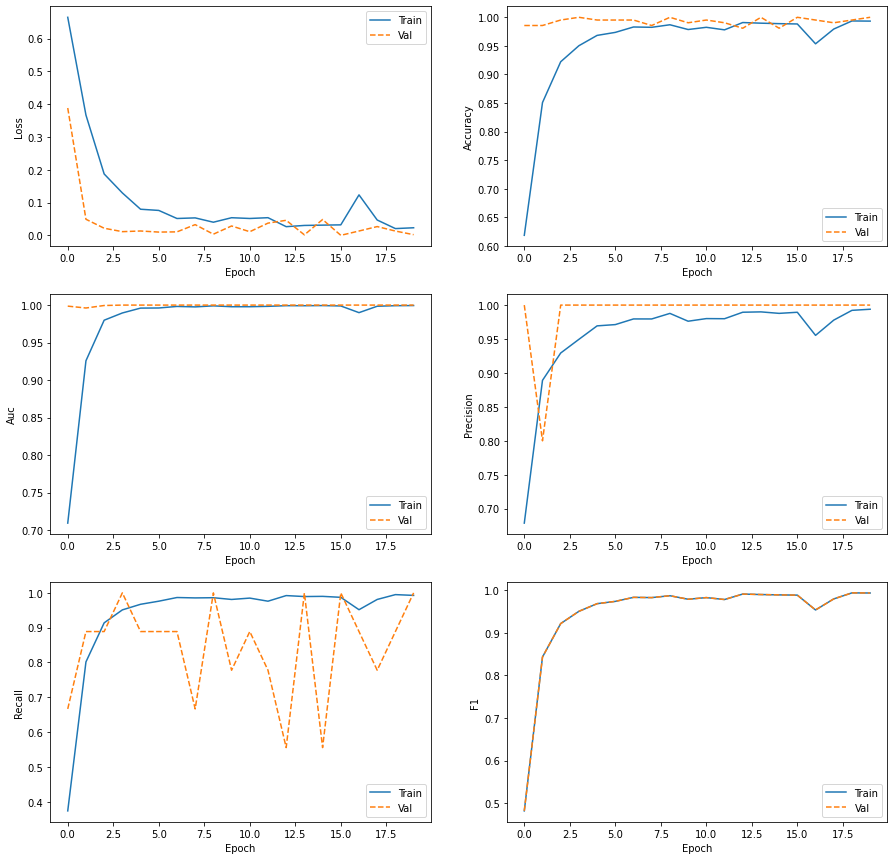

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         9

    accuracy                           1.00       209
   macro avg       1.00      1.00      1.00       209
weighted avg       1.00      1.00      1.00       209


Iteration 4


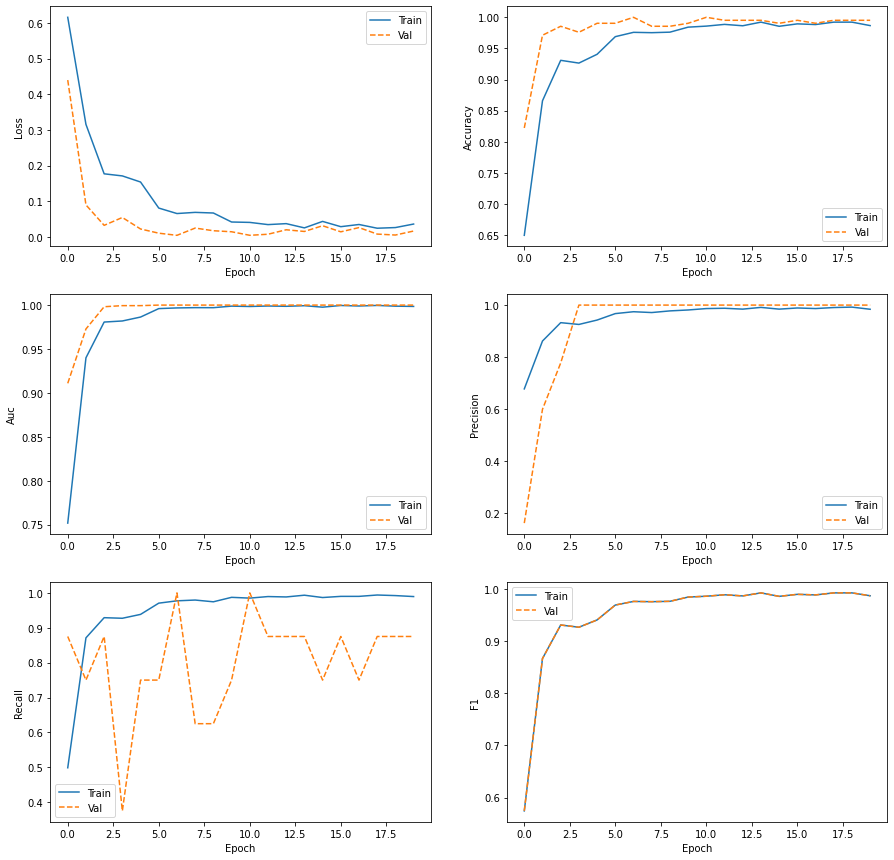

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.88      0.93         8

    accuracy                           1.00       208
   macro avg       1.00      0.94      0.97       208
weighted avg       1.00      1.00      1.00       208


Iteration 5


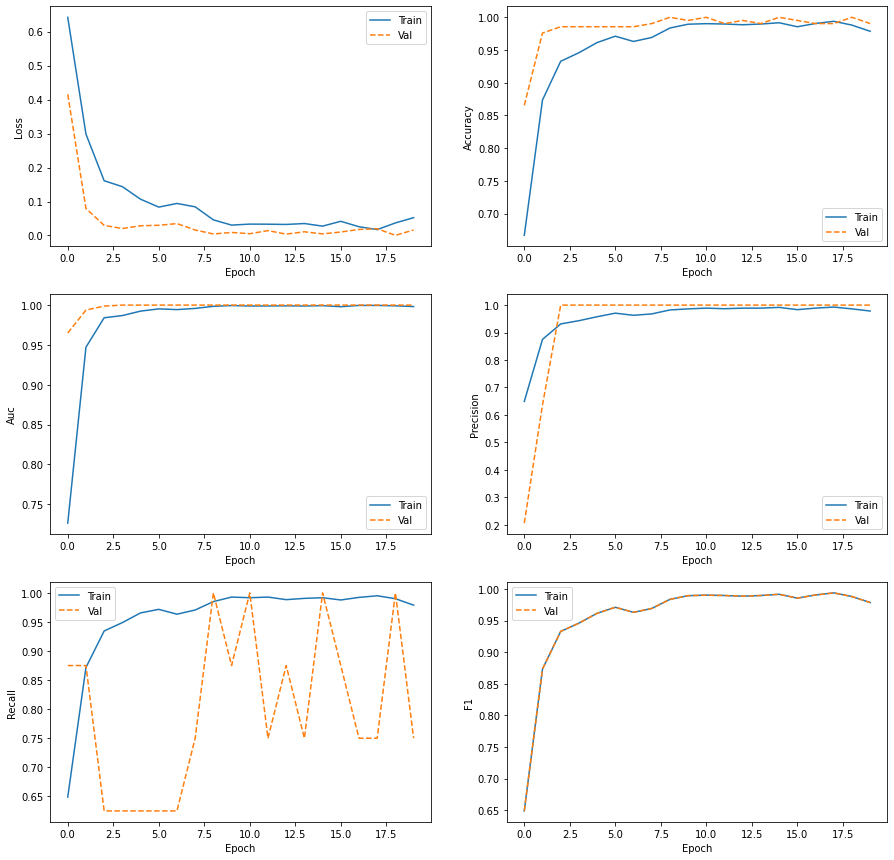

              precision    recall  f1-score   support

    No Covid       0.99      1.00      1.00       200
       Covid       1.00      0.75      0.86         8

    accuracy                           0.99       208
   macro avg       1.00      0.88      0.93       208
weighted avg       0.99      0.99      0.99       208


Iteration 6


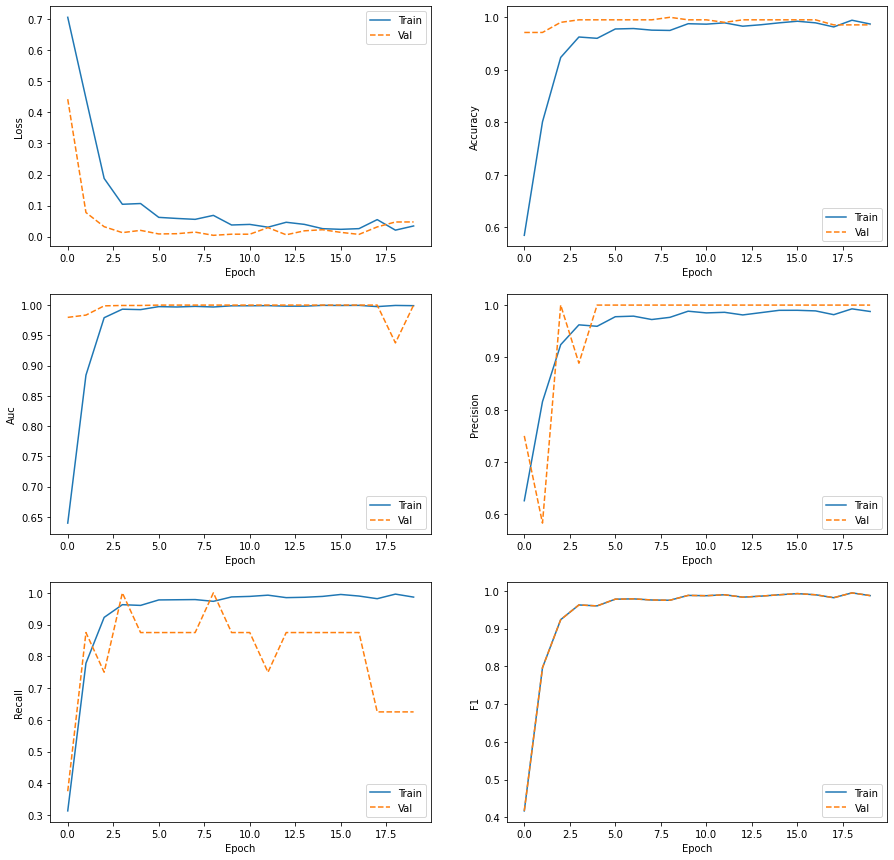

              precision    recall  f1-score   support

    No Covid       0.99      1.00      0.99       200
       Covid       1.00      0.62      0.77         8

    accuracy                           0.99       208
   macro avg       0.99      0.81      0.88       208
weighted avg       0.99      0.99      0.98       208


Iteration 7


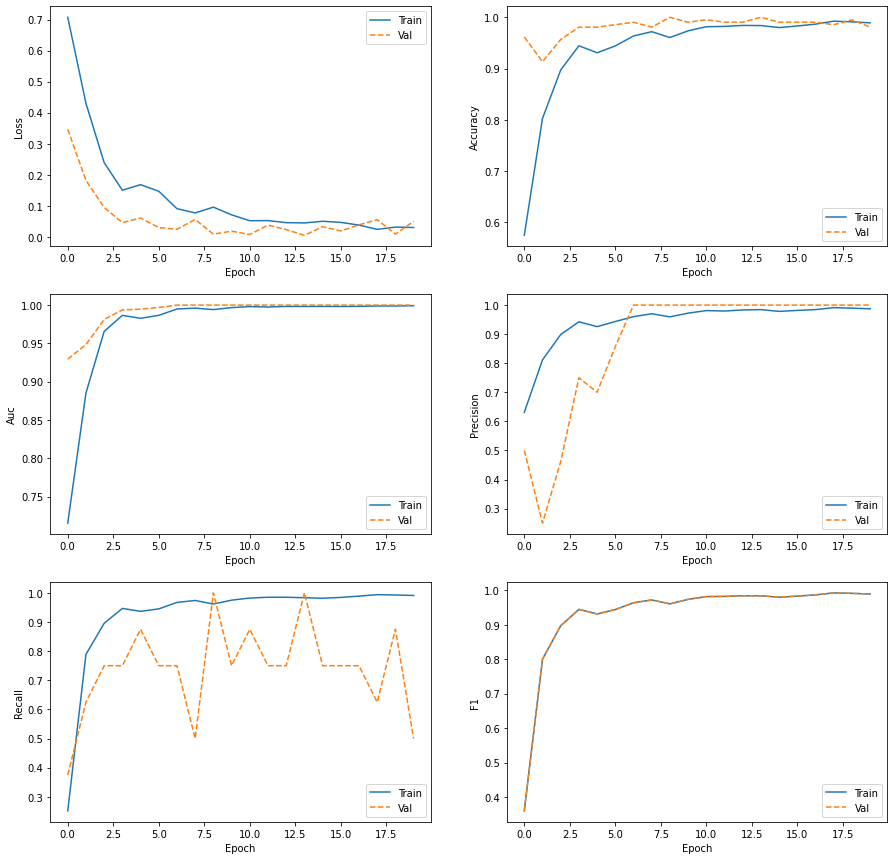

              precision    recall  f1-score   support

    No Covid       0.98      1.00      0.99       200
       Covid       1.00      0.50      0.67         8

    accuracy                           0.98       208
   macro avg       0.99      0.75      0.83       208
weighted avg       0.98      0.98      0.98       208


Iteration 8


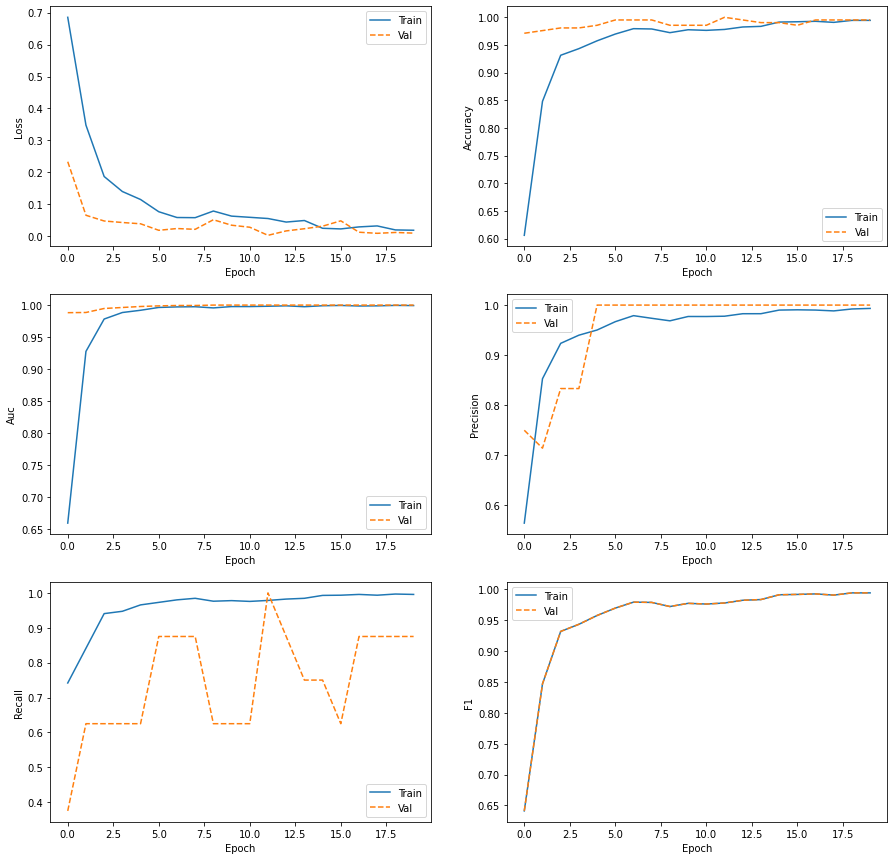

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      0.88      0.93         8

    accuracy                           1.00       208
   macro avg       1.00      0.94      0.97       208
weighted avg       1.00      1.00      1.00       208


Iteration 9


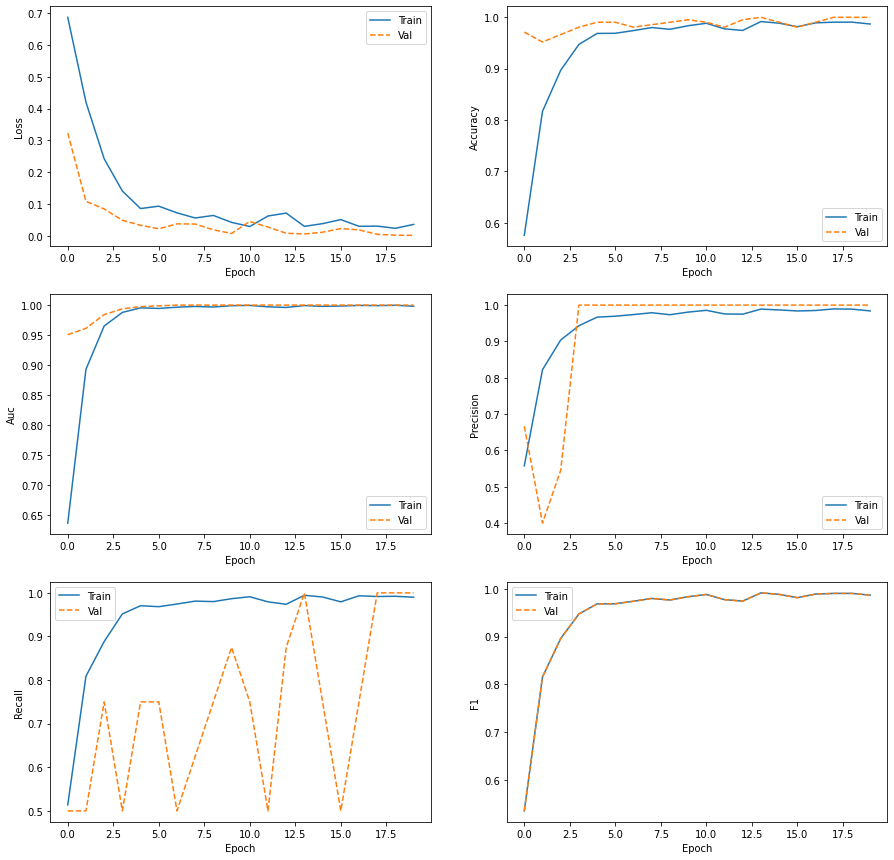

              precision    recall  f1-score   support

    No Covid       1.00      1.00      1.00       200
       Covid       1.00      1.00      1.00         8

    accuracy                           1.00       208
   macro avg       1.00      1.00      1.00       208
weighted avg       1.00      1.00      1.00       208


Whole K-Fold Evaluation
Confusion Matrix
[[2000    0]
 [  21   63]]
Classification Report
              precision    recall  f1-score   support

    No Covid       0.99      1.00      0.99      2000
       Covid       1.00      0.75      0.86        84

    accuracy                           0.99      2084
   macro avg       0.99      0.88      0.93      2084
weighted avg       0.99      0.99      0.99      2084

['0:17:28.665639', '0:16:50.977236', '0:16:53.088079', '0:17:35.469188', '0:16:58.825834', '0:17:41.293200', '0:17:01.830142', '0:18:00.412441', '0:17:16.460957', '0:15:50.291006']




# Load Histories

History 0


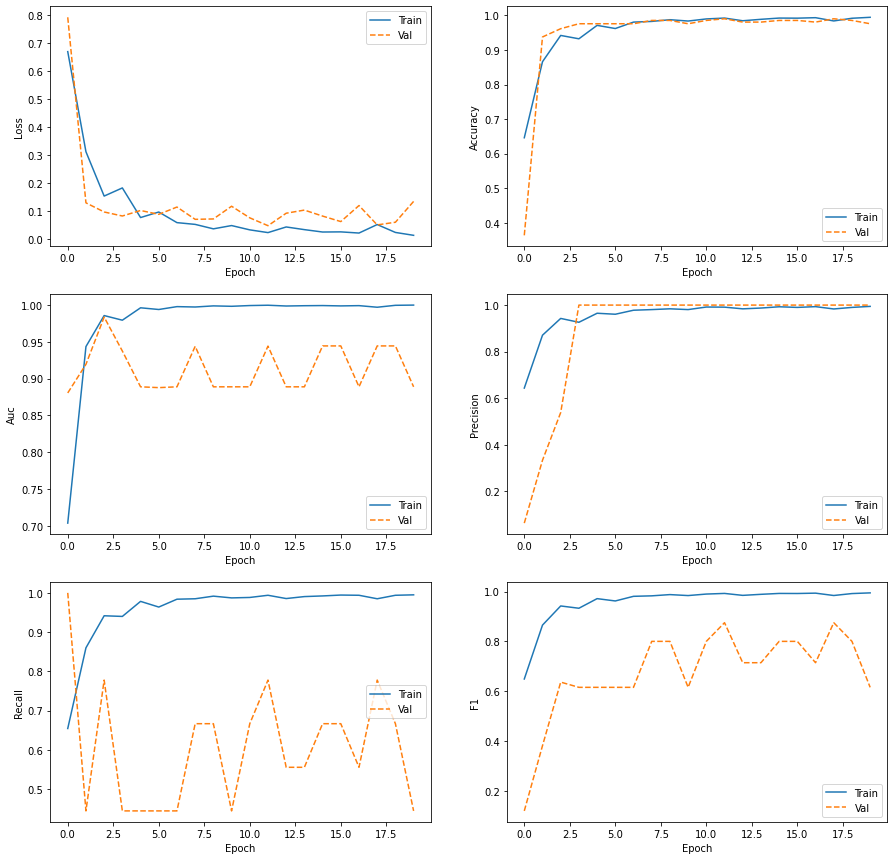

History 1


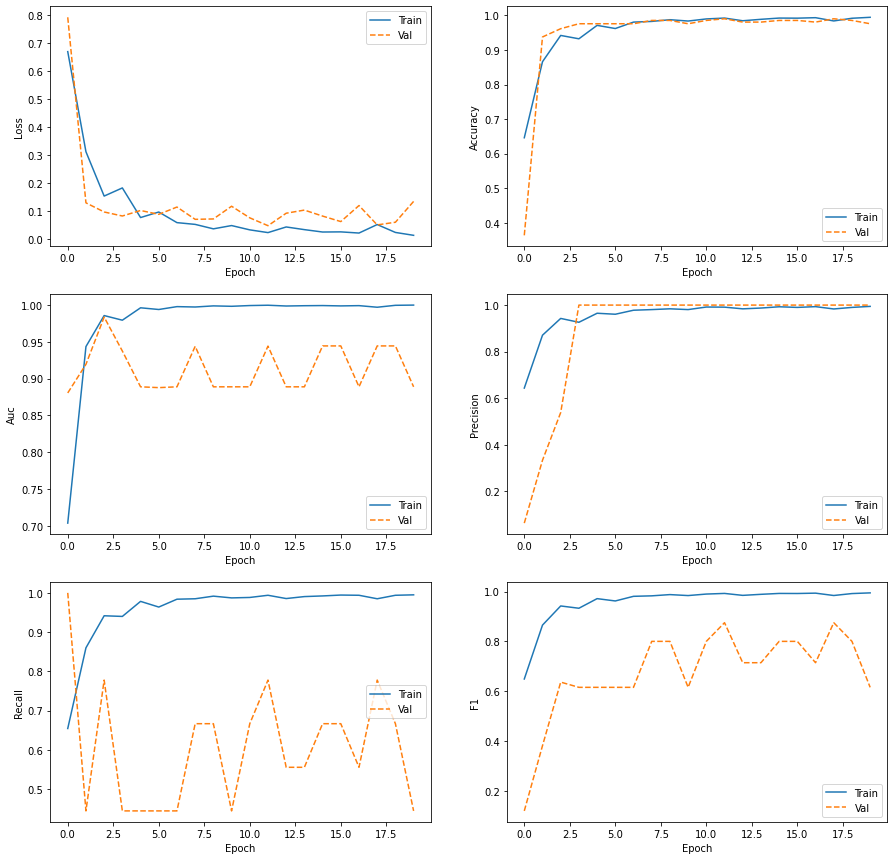

History 2


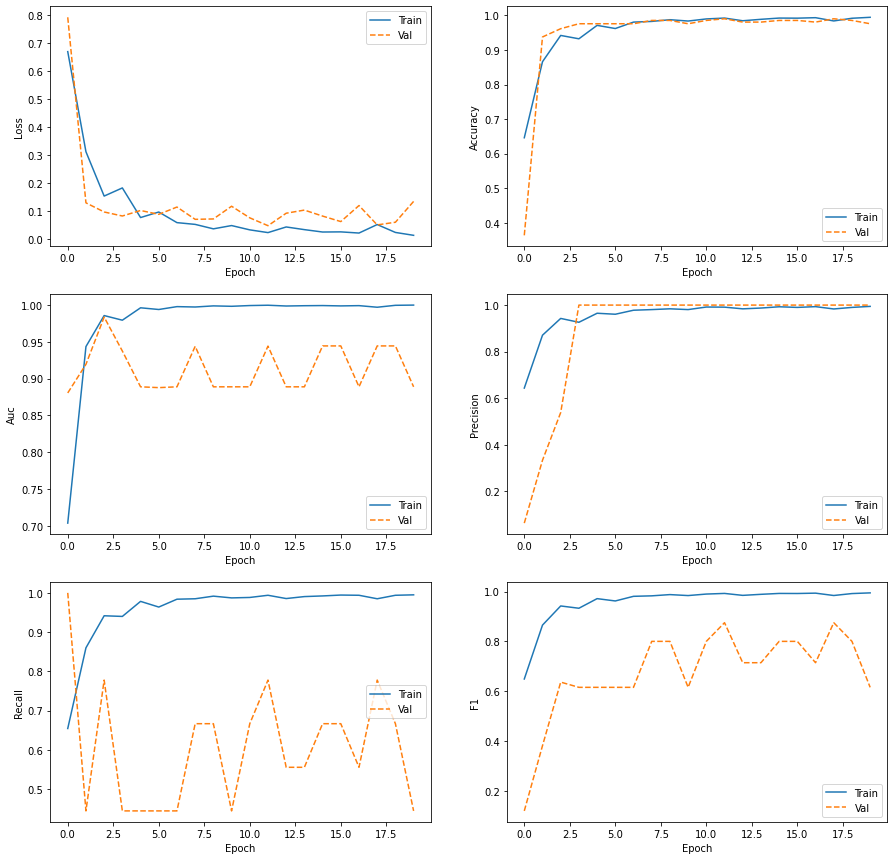

History 3


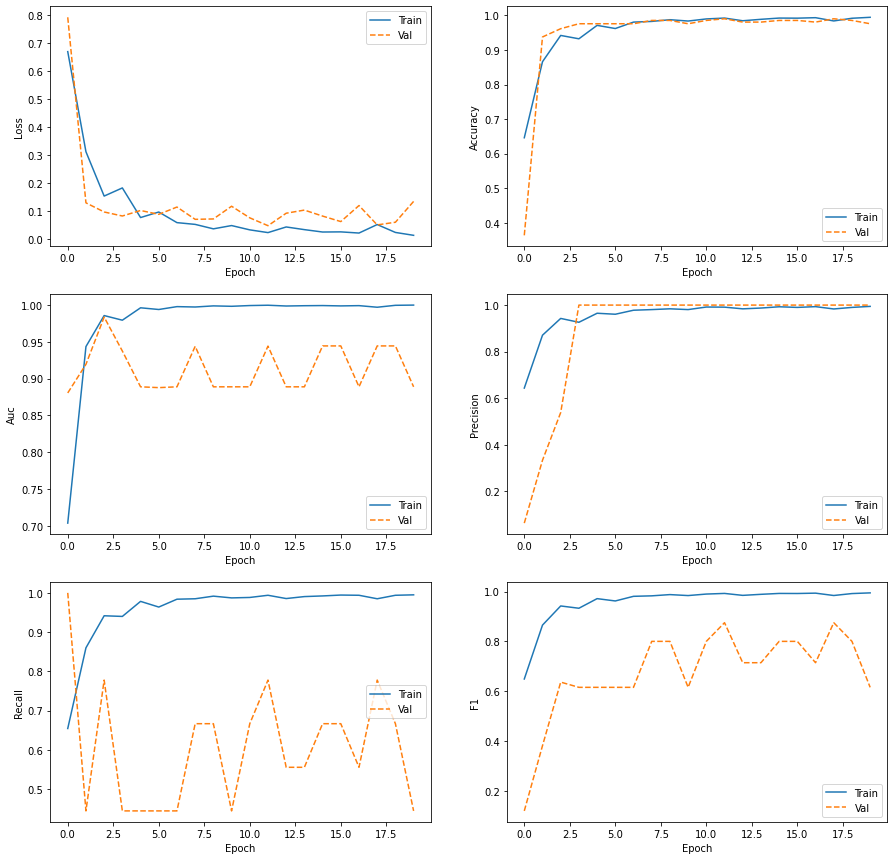

History 4


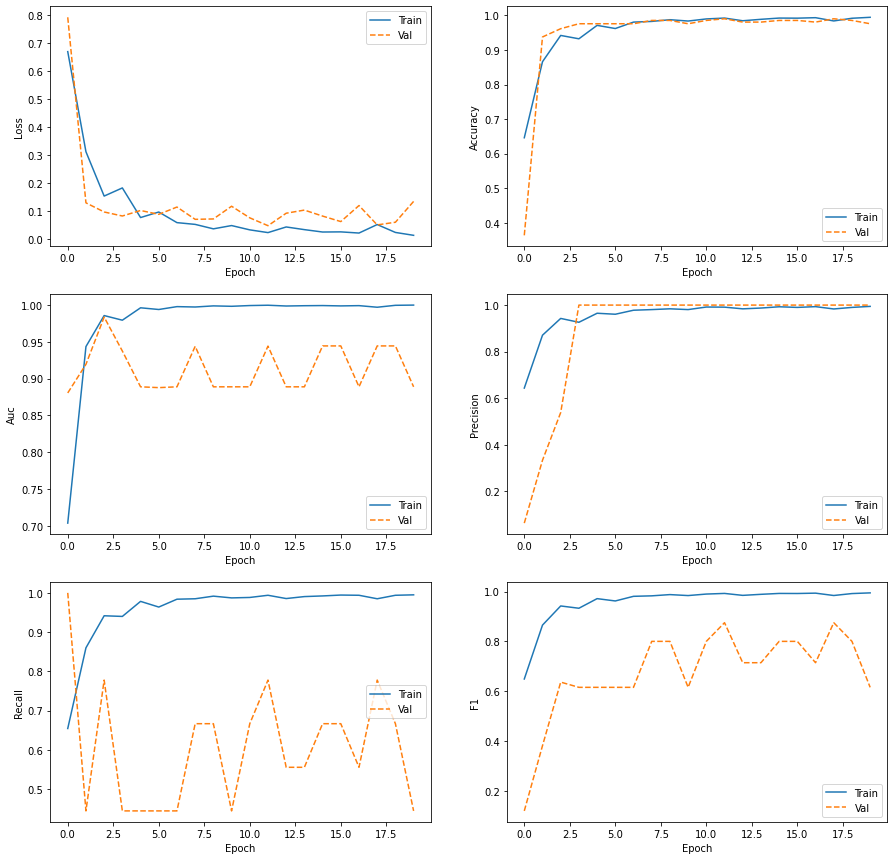

In [4]:
model_number = 1
number_of_its = 5
for i in range(number_of_its):
  history = json.load(open("/content/drive/MyDrive/DL Project/Covid/histories/model"+str(model_number)+"/history_model"+str(model_number)+"_fold"+str(i)+".json", 'r'))
  print("History " + str(i))
  plot_metrics(history)